# Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
%matplotlib notebook

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8); prop = font
proplr = fm.FontProperties(fname = fontloc,size = 12)

fontlocit = pwd + '/Fonts/SFMono-RegularItalic.otf'
fontit = fm.FontProperties(fname = fontlocit,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)
        
def xticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
        
def yticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str("{0:.1f}".format(x)) if x < 0 else str("{0:.2f}".format(x))
    return label

In [2]:
#sample initial conditions
Toi = 1.0
Tai = 1.0

# model parameters, variables and functions
tune = 0.10           #model tuning parameter
Coo = -1.08 * tune
Coa = 1.0 * tune
Cao = 0.1 * tune
Caa = -1.12 * tune
m = 10.0

# define forcing function (weiner process with <cross-section>)
scale = 0.10          #relative amplitude of stochastic forcing
crosssec = scale * Tai
#crosssec = 0.0

# time series
ini = 200             #initialisation
t_start = 0.0
t_end = 3000.0 + ini
time_samples = 3000 + ini
resolution = (t_end - t_start)/time_samples

# DA samples
time_stable = ini/(t_end - t_start)     #ignore first <N> samples as DA stabilises; fraction of total DA steps

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def f(x,t):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

In the presence of the stochastic forcing term(s), one must find alternative ways to solve the coupled ODEs as <font color='red'>scipy.integrate.odeint()</font> wouldn't work in this case. We use <font color='blue'>sdeint()</font> in this case.

In [3]:
import sdeint

# set white noise forcing amplitude
W = np.diag([0.0,crosssec])

# redefine unforced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforc(x, t):
    return C.dot(x)

def forc(x, t):
    return W

In [4]:
#solve the system of ODEs with a sample set of initial conditions
samples = 50
rand.seed(546)     #to fix initial conditions
Toi_lim = Toi      #maximum amplitude of variability in ocean
Tai_lim = Tai      #maximum amplitude of variability in atmosphere
peak_corr = []
To_l = []; Ta_l = []

#calculate trajectories for all samples
VecCorr = []; LagCorr = []
for i in range(samples):
    x0 = [rand.uniform(-Toi_lim, Toi_lim), rand.uniform(-Tai_lim, Tai_lim)]
    soln = sdeint.itoint(unforc,forc,x0,t)
    To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
    Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
    [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
    VecCorr.append(crosscor); LagCorr.append(lag_time)
    max_index = np.argmax(crosscor)
    peak_corr.append(abs(lag_time[max_index]))
    

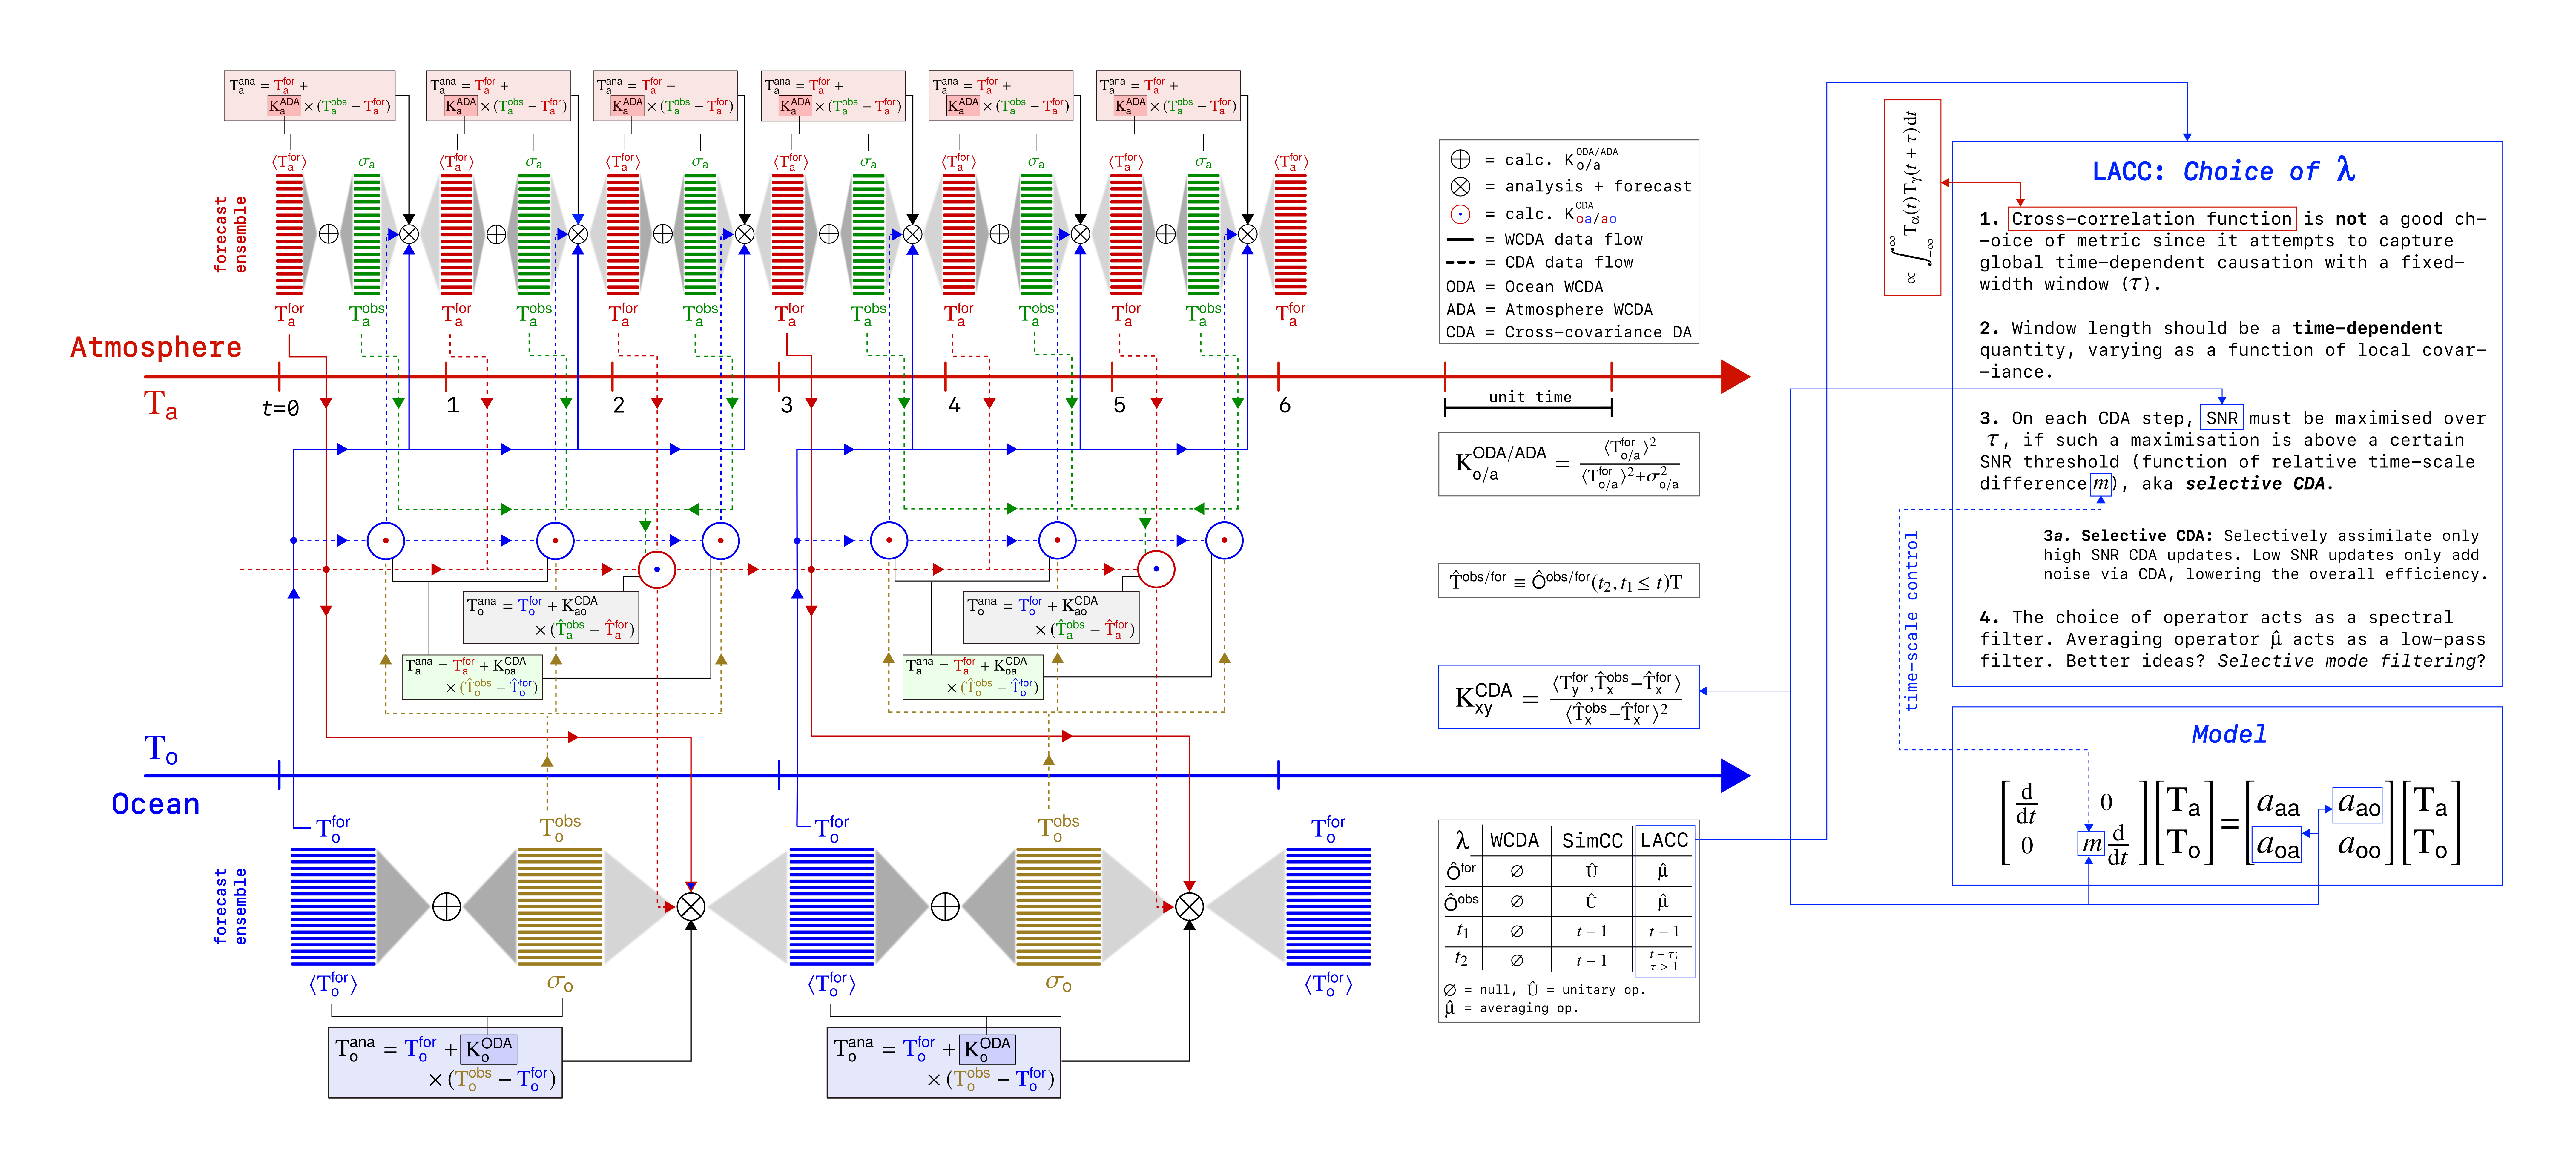

In [5]:
from IPython.display import Image
Image(filename=pwd + '/Liu15.png') 

# Leading average cross-correlation (LACC)

Considering LACC [[Lu15](https://www.dropbox.com/s/0bmtizuck5yafto/Lu15a.pdf?dl=0)] and the results in previous section, the Kalman gain is maximised when the average of $\mathsf{N}$ leading atmospheric forecasts are selected for the analysis step in SCDA. This dependence of Kalman gain on leading forecasts is written as

$$\mathsf{K} = \frac{\langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle}{\langle\overline{\mathsf{T_A}(t_1,t_2)}\rangle + \displaystyle\frac{\sigma_{\mathsf{A},\mathit{o}}^2}{\tau}} \propto \langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle$$

where, $t_1 < t_2 \leq t$ contains $\mathsf{N}$ leading atmospheric forecasts and $\tau = |t_1 - t_2|$. In principle, in regions where the oceanic and atmopheric forecasts are strongly correlated, deviations from the forecasts, as obtained through observations, provide the highest signal-to-noise ratio (SNR) for the analysis step of the DA. This is the core ideology behind the [LACC](https://www.dropbox.com/s/0bmtizuck5yafto/Lu15a.pdf?dl=0) method. For simplicity, we'll term the factor $\langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle$ as 'Kalman Gain', if/when required for simplicity.

Note: The <font color='blue'>KalGain()</font> function sets the DA step size equal to the peak cross-correlation lag time.

# Fourier space: 

Taking the fourier transform of the coupled set of ODEs:


$$\displaystyle2\pi i\mathsf{m} f\,\hat{\mathsf{T}}_\mathsf{A}(f) = \mathrm{C}_\mathsf{AA}\hat{\mathsf{T}}_\mathsf{O}(f) + \mathrm{C}_\mathsf{OA}\hat{\mathsf{T}}_\mathsf{A}(f),$$

$$\displaystyle 2\pi i f\,\hat{\mathsf{T}}_\mathsf{A}(f) = \mathrm{C}_\mathsf{AO}\hat{\mathsf{T}}_\mathsf{O}(f) + \mathrm{C}_\mathsf{AA}\hat{\mathsf{T}}_\mathsf{A}(f) + \hat{\mathsf{F}}(f).$$

where, for white noise $\hat{\mathsf{F}}(f) = \gamma$ is a constant. Solving the set of equations in fourier space yields:

$$\hat{\mathsf{T}}_\mathsf{O}(f)=\gamma\frac{\mathrm{C}_\mathsf{OA}}{(2\pi i f - \mathrm{C}_\mathsf{AA})(2\pi i\mathsf{m} f - \mathrm{C}_\mathsf{OO}) - \mathrm{C}_\mathsf{OA}\mathrm{C}_\mathsf{AO}}$$

$$\hat{\mathsf{T}}_\mathsf{A}(f)=\gamma\frac{2\pi i\mathsf{m} f - \mathrm{C}_\mathsf{OO}}{(2\pi i f - \mathrm{C}_\mathsf{AA})(2\pi i\mathsf{m} f - \mathrm{C}_\mathsf{OO}) - \mathrm{C}_\mathsf{OA}\mathrm{C}_\mathsf{AO}}$$

Furthermore, equating 

$$|\hat{\mathsf{T}}_\mathsf{O}(f)|^2=|\hat{\mathsf{T}}_\mathsf{A}(f)|^2 \rightarrow 0$$
and
$$|\hat{\mathsf{T}}_\mathsf{O}(f)|^2=|\hat{\mathsf{T}}_\mathsf{A}(f)|^2 \rightarrow \infty$$

gives the singular points in the fourier space. In particular, the $\infty$ is interesting.

**Kalman Gain**

Similarly the fourier transform of the Kalman Gain expression

$$\mathsf{K} = \frac{\langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle}{\langle\overline{\mathsf{T_A}(t_1,t_2)}\rangle + \displaystyle\frac{\sigma_{\mathsf{A},\mathit{o}}^2}{\tau}}$$

yields

$$\hat{\mathsf{K}}_\mathsf{L}(f) = \frac{\hat{\mathsf{T}}_\mathsf{O}(f)}{\bigg[ [\mathcal{F}(f)]^2 + \displaystyle\frac{\sigma_{\mathsf{A},\mathit{o}}^2}{\tau} \bigg]} \mathcal{F}(f)$$

where, $\mathcal{F}(f) = \langle$Sinc$(\pi f \tau)\, e^{-2\pi i f t_1} , \hat{\mathsf{T}}_\mathsf{A}(f)\rangle$, and $\tau=|t_1-t_2|$. This expression is a complete spectral description of the Kalman gain for the *LACC* method. 




In [6]:
import warnings
warnings.filterwarnings("error")

#set DA variables for LACC simulation
atm_var = 0.05      #intrinsic error variance in atmospheric observations 
atm_syn = 0.05      #induced error variance in atmospheric observations
oce_var = 0.02      #intrinsic error variance in oceanic observations 
win = 100           #LACC    
NaN = np.float('nan')

def myround(x, base):
    return base * round(x/base)

def WCDA(ocean_v, atmos_v, t, win, item, atm_obs, oce_obs, atm_obs_mean):
    oce_for_c = []; atm_for_c = []; oce_for = []; atm_for = []; oce_ana = []; atm_ana = []
    iter0 = 0; iter1 = 0; flag = 0; KalGainC = []; KalGainA = [] ; KalGainO = [] 
    oce_gain = 0; atm_gain = 0; oce_gain_c = 0; atm_gain_c = 0
    oce_se = []; atm_se = []
    for num, time in enumerate(t):
        if num < ini:            #initialisation loop for <ini - 1> steps
            ocean = ocean_v[num];  atmos = atmos_v[num]
            oce_for.append(ocean); atm_for.append(atmos)
            if num > 0:          #offset
                oce_ana.append(ocean); atm_ana.append(atmos)
            else:
                oce_ana.append(NaN); atm_ana.append(NaN)
            KalGainO.append(0.0); KalGainA.append(0.0)
            oce_se.append(np.abs(oce_for[-1] - oce_obs[num])**2)
            atm_se.append(np.abs(atm_for[-1] - atm_obs[num])**2)
            flag = 'None'
        else:                    #start DA after <ini> time steps
            if time % win == 0.0 and num > win - 1: 
                #print(num,'SCDA')    
                try:
                    covar_matrix   = np.cov(np.array([oce_for,atm_for]))
                    var_atm   =   covar_matrix[1][1]
                    var_oce   =   covar_matrix[0][0]
                    flag = 'lowered WCDA'
                except RuntimeWarning:
                    var_atm   = 0.0; var_oce   = 0.0
                    flag = 'raised WCDA' 
                
                Ka = ((var_atm))/((var_atm) + (atm_var)**2)
                Ko = ((var_oce))/((var_oce) + (oce_var)**2)
                oce_gain   = Ko * (oce_obs[num - 1] - oce_for[-1])
                atm_gain   = Ka * (atm_obs[num - 1] - atm_for[-1])
                KalGainO.append(Ko); KalGainA.append(Ka)
                #CDA
                ocean = oce_for[-1] + oce_gain
                atmos = atm_for[-1] + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                sol   = sdeint.itoint(unforc,forc,[ocean,atmos],[0,1])
                oce_for.append(sol[0,1])
                atm_for.append(sol[1,1])
                oce_se.append(np.abs(oce_for[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_for[-1] - atm_obs[num])**2)
                iter1 = iter1 + 1; iter0 = iter0 + 1
            else:
                #print(num,'WCDA')
                try:
                    covar_matrix = np.cov(np.array([oce_for,atm_for]))
                    var_oce = covar_matrix[0][0]
                    var_atm = covar_matrix[1][1]
                    flag = 'lowered WDA'
                except RuntimeWarning:
                    var_oce = 0.0; var_atm = 0.0
                    flag = 'raised WDA'
                Ka = ((var_atm))/((var_atm) + (atm_var)**2)
                Ko = ((var_oce))/((var_oce) + (oce_var)**2)
                oce_gain = Ko * (oce_obs[num - 1] - oce_for[-1])
                atm_gain = Ka * (atm_obs[num - 1] - atm_for[-1])
                KalGainO.append(Ko); KalGainA.append(Ka)
                oce_gain_c = 0; atm_gain_c = 0
                ocean = oce_for[-1] + oce_gain_c + oce_gain
                atmos = atm_for[-1] + atm_gain_c + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                sol   = sdeint.itoint(unforc,forc,[ocean,atmos],[0,1])
                oce_for.append(sol[0,1])
                atm_for.append(sol[1,1])
                oce_se.append(np.abs(oce_for[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_for[-1] - atm_obs[num])**2)
                iter1 = iter1 + 1        
    return KalGainO, KalGainA, oce_for, atm_for, oce_se, atm_se, oce_ana, atm_ana

def SCDA(ocean_v, atmos_v, t, win, item, atm_obs, oce_obs, atm_obs_mean):
    oce_for_c = []; atm_for_c = []; oce_for = []; atm_for = []; oce_ana = []; atm_ana = []
    iter0 = 0; iter1 = 0; flag = 0; KalGainC = []; KalGainA = [] ; KalGainO = [] 
    oce_gain = 0; atm_gain = 0; oce_gain_c = 0; atm_gain_c = 0
    oce_se = []; atm_se = []
    for num, time in enumerate(t):
        if num < ini:            #initialisation loop for <ini - 1> steps
            ocean = ocean_v[num];  atmos = atmos_v[num]
            oce_for.append(ocean); atm_for.append(atmos)
            if num > 0:          #offset
                oce_ana.append(ocean); atm_ana.append(atmos)
            else:
                oce_ana.append(NaN); atm_ana.append(NaN)
            KalGainO.append(0.0); KalGainA.append(0.0)
            oce_se.append(np.abs(oce_for[-1] - oce_obs[num])**2)
            atm_se.append(np.abs(atm_for[-1] - atm_obs[num])**2)
            flag = 'None'
        else:                    #start DA after <ini> time steps
            if time % win == 0.0 and num > win - 1: 
                #print(num,'SCDA')    
                oce_mean = ocean                                         #no averaging for ocean
                oce_for_c.append(oce_mean)
                atm_mean = np.mean(atm_for[num - win:num])               #mean over previous <win> times for atmos
                atm_for_c.append(atm_mean)
                try:
                    covar_matrix_c = np.cov(np.array([oce_for_c,atm_for_c]))
                    covar_c   = covar_matrix_c[0][1]
                    var_atm_c = covar_matrix_c[1][1]
                    var_oce_c = covar_matrix_c[0][0]
                    covar_matrix   = np.cov(np.array([oce_for,atm_for]))
                    covar     =   covar_matrix[0][1]
                    var_atm   =   covar_matrix[1][1]
                    var_oce   =   covar_matrix[0][0]
                    flag = 'lowered CDA'
                except RuntimeWarning:
                    covar_c   = 0.0; var_atm_c = 0.0; var_oce_c = 0.0
                    covar     = 0.0; var_atm   = 0.0; var_oce   = 0.0
                    flag = 'raised CDA' 
                
                #print(flag,covar_c, oce_for, atm_for)
                Kc = covar/(var_atm_c + ((atm_syn**2)/win))
                Ka = ((var_atm))/((var_atm) + (atm_var)**2)
                Ko = ((var_oce))/((var_oce) + (oce_var)**2)
                oce_gain_c = Kc * (atm_obs_mean[iter0] - atm_mean)
                oce_gain   = Ko * (oce_obs[num - 1] - oce_for[-1])
                atm_gain   = Ka * (atm_obs[num - 1] - atm_for[-1])
                KalGainC.append(Kc); KalGainO.append(Ko); KalGainA.append(Ka)
                #CDA
                ocean = oce_for[-1] + oce_gain_c + oce_gain
                atmos = atm_for[-1] + atm_gain_c + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                sol   = sdeint.itoint(unforc,forc,[ocean,atmos],[0,1])
                oce_for.append(sol[0,1])
                atm_for.append(sol[1,1])
                oce_se.append(np.abs(oce_for[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_for[-1] - atm_obs[num])**2)
                iter1 = iter1 + 1; iter0 = iter0 + 1
            else:
                #print(num,'WCDA')
                try:
                    covar_matrix = np.cov(np.array([oce_for,atm_for]))
                    var_oce = covar_matrix[0][0]
                    var_atm = covar_matrix[1][1]
                    flag = 'lowered WDA'
                except RuntimeWarning:
                    var_oce = 0.0; var_atm = 0.0
                    flag = 'raised WDA'
                Ka = ((var_atm))/((var_atm) + (atm_var)**2)
                Ko = ((var_oce))/((var_oce) + (oce_var)**2)
                oce_gain = Ko * (oce_obs[num - 1] - oce_for[-1])
                atm_gain = Ka * (atm_obs[num - 1] - atm_for[-1])
                KalGainO.append(Ko); KalGainA.append(Ka)
                oce_gain_c = 0; atm_gain_c = 0
                ocean = oce_for[-1] + oce_gain_c + oce_gain
                atmos = atm_for[-1] + atm_gain_c + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                sol   = sdeint.itoint(unforc,forc,[ocean,atmos],[0,1])
                oce_for.append(sol[0,1])
                atm_for.append(sol[1,1])
                oce_se.append(np.abs(oce_for[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_for[-1] - atm_obs[num])**2)
                iter1 = iter1 + 1    
    return KalGainC, KalGainO, KalGainA, oce_for, atm_for, oce_se, atm_se, oce_ana, atm_ana

KalCovMat = []; KalCovMax = []; KalCovMaxVal = []
KalAMat   = [];   KalAMax = [];   KalAMaxVal = []
KalOMat   = [];   KalOMax = [];   KalOMaxVal = []
atm_obs   = [];   oce_obs = []; atm_obs_mean = []
atm_mse   = [];   oce_mse = []
atm_mseW  = [];  oce_mseW = []
oce_for_save  = []; atm_for_save  = []
oce_for_saveW = []; atm_for_saveW = []
oce_ana_save  = []; atm_ana_save  = []
oce_ana_saveW = []; atm_ana_saveW = []

#read observation file
To_s = []; Ta_s = []
with open(pwd + '/ToyModel_1/Data/Oce_S_obs_W.log') as f:
    for line in f.readlines():
          To_s.append(float(line))
with open(pwd + '/ToyModel_1/Data/Atm_S_obs_W.log') as f:
    for line in f.readlines():
          Ta_s.append(float(line))
np.random.seed(1)
atm_obs = [val + np.random.normal(0.0, atm_var, 1) for val in Ta_s]     #atmos obs vector
oce_obs = [val + np.random.normal(0.0, oce_var, 1) for val in To_s]     #ocean obs vector

for num, time in enumerate(t):
    if time % win == 0.0 and num > win - 1:
        mean_val = (np.mean(atm_obs[num - win:num])) + ((np.random.normal(0.0, atm_syn, 1))/np.sqrt(win))
        atm_obs_mean.append(mean_val[-1])                                  #perturbed mean vector atmos
            
for i in range(samples):
    To_t = To_l[i][:ini]   
    Ta_t = Ta_l[i][:ini] 
    KalCovVec, KalOVec, KalAVec, oce_for, atm_for, oce_se, atm_se, oce_ana, atm_ana  = SCDA(To_t, Ta_t, t, win, i, atm_obs, oce_obs, atm_obs_mean) #passing win>1 ensures LACC method
    KalOVecW, KalAVecW, oce_forW, atm_forW, oce_seW, atm_seW, oce_anaW, atm_anaW     = WCDA(To_t, Ta_t, t, win, i, atm_obs, oce_obs, atm_obs_mean) #passing win>1 ensures LACC method
    time_ignoreCov = int(np.floor(time_stable*len(KalCovVec)))             #ignore fraction of preceding analysis
    time_ignore    = int(np.floor(time_stable*len(KalAVec)))               #ignore fraction of preceding analysis
    KalCovVec[:time_ignoreCov] = []; KalAVec[:time_ignore] = []; KalOVec[:time_ignore] = []
    KalCovMat.append(KalCovVec); KalAMat.append(KalAVec); KalOMat.append(KalOVec)
    KalCovMax.append(np.argmax((KalCovVec))); KalAMax.append(np.argmax((KalAVec))); KalOMax.append(np.argmax((KalOVec)))
    KalCovMaxVal.append(np.max((KalCovVec))); KalAMaxVal.append(np.max((KalAVec))); KalOMaxVal.append(np.max((KalOVec)))   
    oce_for_save.append(oce_for);   atm_for_save.append(atm_for)
    oce_for_saveW.append(oce_forW); atm_for_saveW.append(atm_forW)
    oce_ana_save.append(oce_ana);   atm_ana_save.append(atm_ana)
    oce_ana_saveW.append(oce_anaW); atm_ana_saveW.append(atm_anaW)  
    oce_mse.append(oce_se);   atm_mse.append(atm_se) 
    oce_mseW.append(oce_seW); atm_mseW.append(atm_seW)
    
KalCovMatRaw = KalCovMat
time_stab    = t[time_ignore:]
oce_rmse     = np.sqrt(np.mean(oce_mse, axis=0))
atm_rmse     = np.sqrt(np.mean(atm_mse, axis=0))
oce_rmseW    = np.sqrt(np.mean(oce_mseW, axis=0))
atm_rmseW    = np.sqrt(np.mean(atm_mseW, axis=0))

lengths_c = []; power2_c = []
for row in KalCovMat:
    lengths_c.append(len(row))
    power2_c.append(np.sum(row)/len(row))
lengths_o = []; power2_o = []
for row in KalOMat:
    lengths_o.append(len(row))
    power2_o.append(np.sum(row)/len(row))
lengths_a = []; power2_a = []
for row in KalAMat:
    lengths_a.append(len(row))
    power2_a.append(np.sum(row)/len(row))

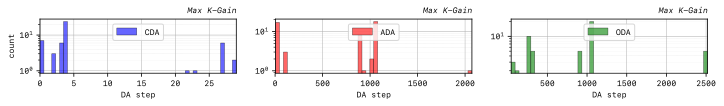

In [7]:
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = 'svg'
        
#plot kalman gain statistics vs DA steps
#--Cov
fig = plt.figure(figsize=(12,1), dpi=200);
plt.subplot(1, 3, 1)
plt.hist(KalCovMax,alpha=0.6, density=False, edgecolor='black', linewidth=0.5, bins = 50, facecolor='b');
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.xlabel('DA step',fontproperties=font,fontsize=8);
plt.ylabel('count',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
l1 = ax.legend(['CDA'], loc='upper center')
plt.setp(l1.texts, family='SF Mono', fontsize=8); ax.set_yscale('log')
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.set_title('Max K-Gain',fontproperties=fontit,fontsize=8, y=1.00, loc='right');
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

#--Atmopshere
plt.subplot(1, 3, 2)
plt.hist(KalAMax,  alpha=0.6, density=False, edgecolor='black', linewidth=0.5, bins = 50, facecolor='r');
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.xlabel('DA step',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
l1 = ax.legend(['ADA'], loc='upper center')
plt.setp(l1.texts, family='SF Mono', fontsize=8); ax.set_yscale('log')
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.set_title('Max K-Gain',fontproperties=fontit,fontsize=8, y=1.00, loc='right');
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

#--Ocean
plt.subplot(1, 3, 3)
plt.hist(KalOMax,  alpha=0.6, density=False, edgecolor='black', linewidth=0.5, bins = 50, facecolor='g');
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.xlabel('DA step',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
l1 = ax.legend(['ODA'], loc='upper center')
plt.setp(l1.texts, family='SF Mono', fontsize=8); ax.set_yscale('log')
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.set_title('Max K-Gain',fontproperties=fontit,fontsize=8, y=1.00, loc='right');
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

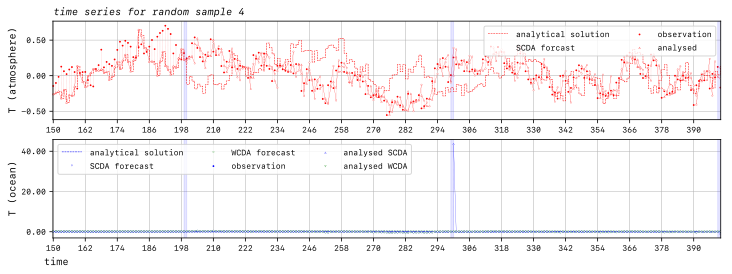

In [11]:
# plot sample time series and RMSE
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = 'svg'

randsamp = np.random.randint(0,samples)
time_plot = [150, 400]
#time_plot = [int(t[0]), int(t[-1])]
stepping  = (time_plot[-1] - time_plot[0])/20

#plot a sample trajectory
fig = plt.figure(figsize=(12,4), dpi=200);
#--Atmopshere
plt.subplot(2, 1, 1)
t_s = t[time_plot[0]:time_plot[-1] + 1]; y1 = atm_ana_save[randsamp][time_plot[0]:time_plot[-1] + 1] 
y2 = atm_for_save[randsamp][time_plot[0]:time_plot[-1] + 1]; y3 = atm_obs[time_plot[0]:time_plot[-1] + 1]
y4 = Ta_l[randsamp][time_plot[0]:time_plot[-1] + 1]
plt.plot(   t_s, y4, '--r', linewidth=0.5, alpha = 1.0, drawstyle='steps-post', marker='.', markersize=0.0, markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.2);
plt.scatter(t_s, y3, marker='.', s=3, c='r', alpha = 1.0);
plt.scatter(t_s, y1, marker='^', s=3, edgecolor='r', alpha = 1.0, facecolor='w', linewidth=0.2);
plt.step(   t_s, y2,  'r', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='r', markeredgewidth=0.2);
for i in range(0, len(t_s)):
    plt.plot([t_s[i], t_s[i]], [min(y2[i],y3[i],y1[i]), max(y2[i],y3[i],y1[i])], '--r', linewidth=0.1, zorder=0, label='_nolegend_')
for i in range(0, len(t_s) - 1):
    plt.plot([t_s[i], t_s[i + 1]], [y1[i], y2[i + 1]], '-r', linewidth=0.2, zorder=0, label='_nolegend_')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.ylabel('T (atmosphere)' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['analytical solution','SCDA forcast','observation','analysed'], loc='best', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('time series for random sample ' + str(randsamp), fontproperties=fontit,fontsize=10, y=1.00, loc='left');
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')
#--Ocean
plt.subplot(2, 1, 2)
t_s = t[time_plot[0]:time_plot[-1] + 1]; y1 = oce_ana_save[randsamp][time_plot[0]:time_plot[-1] + 1] 
y2 = oce_for_save[randsamp][time_plot[0]:time_plot[-1] + 1]; y3 = oce_obs[time_plot[0]:time_plot[-1] + 1]
y4 = To_l[randsamp][time_plot[0]:time_plot[-1] + 1]; y5 = oce_for_saveW[randsamp][time_plot[0]:time_plot[-1] + 1]
y7 = oce_ana_saveW[randsamp][time_plot[0]:time_plot[-1] + 1] 
plt.plot(   t_s, y4, '--b', linewidth=0.5, alpha = 1.0, drawstyle='steps-post', marker='.', markersize=0.0, markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.2);
plt.scatter(t_s, y3, marker='.', s=3, c='b', alpha = 1.0);
plt.scatter(t_s, y1, marker='^', s=3, edgecolor='b', alpha = 1.0, facecolor='w', linewidth=0.2, zorder=2);
plt.scatter(t_s, y7, marker='v', s=3, edgecolor='g', alpha = 1.0, facecolor='w', linewidth=0.2, zorder=2);
plt.step(   t_s, y2,  'b', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='b', markeredgewidth=0.2);
plt.step(   t_s, y5,  'g', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='g', markeredgewidth=0.2);
for i in range(0, len(t_s)):
    plt.plot([t_s[i], t_s[i]], [min(y7[i],y5[i],y3[i]), max(y7[i],y5[i],y3[i])], '--g', linewidth=0.1, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i]], [min(y1[i],y2[i],y3[i]), max(y1[i],y2[i],y3[i])], '--b', linewidth=0.1, zorder=1, label='_nolegend_')
for i in range(0, len(t_s) - 1):
    plt.plot([t_s[i], t_s[i + 1]], [y7[i], y5[i + 1]], '-g', linewidth=0.2, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i + 1]], [y1[i], y2[i + 1]], '-b', linewidth=0.2, zorder=1, label='_nolegend_')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.xlabel('time'      ,fontproperties=font,fontsize=10);
plt.ylabel('T (ocean)' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.2)
l1 = ax.legend(['analytical solution', 'SCDA forecast','WCDA forecast','observation','analysed SCDA', 'analysed WCDA'], loc='best', ncol=3)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')

#plot RMSE
time_plot = [int(t[0]), int(t[-1])]
stepping  = (time_plot[-1] - time_plot[0])/10
fig = plt.figure(figsize=(12,6), dpi=200);
#--Atmopshere
plt.subplot(3, 1, 1)
mean  = np.mean(atm_rmse[time_plot[0]:time_plot[-1] + 1])
meanW = np.mean(atm_rmseW[time_plot[0]:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], atm_rmse[time_plot[0]:time_plot[-1] + 1],  'r', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='r', markeredgecolor='k', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.ylabel('atmosphere' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA (mean = ' + str("{:.6e}".format(mean)) + ')  ' + 'WCDA (mean = ' + str("{:.6e}".format(meanW)) + ')'], loc='best', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('RMSE', fontproperties=fontit,fontsize=10, y=1.00, loc='left');
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')
        
#--Ocean
plt.subplot(3, 1, 2)
mean  = np.mean(oce_rmse[time_plot[0]:time_plot[-1] + 1])
meanW = np.mean(oce_rmseW[time_plot[0]:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], oce_rmse[time_plot[0]:time_plot[-1] + 1],  'b', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='b', markeredgewidth=0.2);
plt.step(t[time_plot[0]:time_plot[-1] + 1], oce_rmseW[time_plot[0]:time_plot[-1] + 1], 'g', linewidth=0.5, alpha = 0.0, where='mid', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='g', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.ylabel('ocean' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA (mean = ' + str("{:.6e}".format(mean)) + ')  ' + 'WCDA (mean = ' + str("{:.6e}".format(meanW)) + ')'], loc='best', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')
        
diff_oce_rmse = [(i - j) for i,j in zip(oce_rmse, oce_rmseW)]
plt.subplot(3, 1, 3)
mean  = np.mean(diff_oce_rmse[time_plot[0]:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], diff_oce_rmse[time_plot[0]:time_plot[-1] + 1],  'k', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='k', markeredgecolor='k', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA - WCDA (mean = ' + str("{:.2e}".format(mean)) + ')'], loc='best', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
plt.xlabel('time'      ,fontproperties=font,fontsize=10); ax.xaxis.set_label_coords(0.005, -0.2)
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')


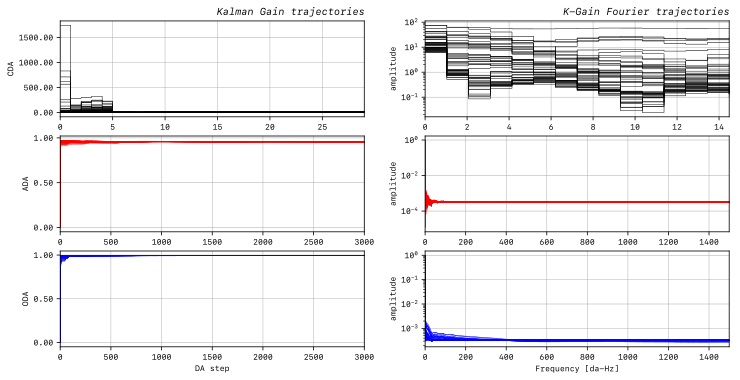

In [9]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
from matplotlib.colors import LogNorm

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

def stretch_to(l, n, insert):
    Out = [insert] * n
    m = len(l)
    if m == 1:
        m = 2
    for i, x in enumerate(l):
        Out[i * (n - 1) // (m - 1)] = x
    return Out

NaN = float('nan')

if 0 == 1:
    #stretched list
    KalCovLong = []
    for row in KalCovMatRaw:
        row_long = stretch_to(row, renorm, NaN)
        row_new = fill_nan(np.array(row_long))
        KalCovLong.append(row_new)

    #make rows equal lengths for plotting
    maxLen = max(map(len, KalCovMat))
    for row in KalCovMat:
        if len(row) < maxLen:
            row.extend(NaN for _ in range(maxLen - len(row)))

    #draw trajectories of Cross-Corr
    fig, ax = plt.subplots(figsize=(40,40), dpi=200);
    #PlotMat = np.array(KalCovMat).transpose()
    PlotMat = np.array(KalCovMat)
    im = ax.matshow(PlotMat,origin='lower');
    ax.grid(which='minor')
    ax.set_aspect(1.0)

    #colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="3%", pad = 0.1)
    cb = plt.colorbar(im, cax=cax,label='Kalman Gain',orientation="horizontal");
    axc = cb.ax
    text = axc.xaxis.label
    text.set_font_properties(proplr)
    ticks(axc,10);

    ax.set_xlabel('DA step',fontproperties=font,fontsize=12); 
    ax.xaxis.set_label_position('top');
    ax.set_ylabel('sample number',fontproperties=font,fontsize=12); 

    ticks(ax,10);
    ax.set_title('Kalman Gain trajectories',fontproperties=fontit,fontsize=12, y=1.15, loc='left');

#--Cov
#line plot
plt.figure(figsize=(12,6),dpi=200);
plt.subplot(3, 2, 1)
for row in KalCovMat:
    plt.plot(row, c='black', linewidth=0.5, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
plt.ylabel('CDA',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_title('Kalman Gain trajectories',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#frequency space
FFT = []; FQ = []
for row in KalCovMat:
    ts= len(row)
    F = np.fft.fft(row)
    FFT.append(np.abs(F)[:ts // 2] * 1 / ts)
Q  = np.linspace(0, ts, ts)
FQ.append(Q[:ts // 2])
plt.subplot(3, 2, 2)
for row in FFT:
    plt.plot(np.array(FQ).transpose(), row, c='black', linewidth=0.5, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_title('K-Gain Fourier trajectories',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
ax.set_yscale('log')

#--Atmosphere
plt.subplot(3, 2, 3)
for row in KalAMat:
    plt.plot(row, c='r', linewidth=0.5, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
plt.ylabel('ADA',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#frequency space
FFT = []; FQ = []
for row in KalAMat:
    ts= len(row)
    F = np.fft.fft(row)
    FFT.append(np.abs(F)[:ts // 2] * 1 / ts)
Q  = np.linspace(0, ts, ts)
FQ.append(Q[:ts // 2])
plt.subplot(3, 2, 4)
for row in FFT:
    plt.plot(np.array(FQ).transpose(), row, c='r', linewidth=0.5, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_yscale('log')

#--Ocean
plt.subplot(3, 2, 5)
for row in KalOMat:
    plt.plot(row, c='b', linewidth=0.5, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.xlabel('DA step',fontproperties=font,fontsize=8);
plt.ylabel('ODA',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#frequency space
FFT = []; FQ = []
for row in KalOMat:
    ts= len(row)
    F = np.fft.fft(row)
    FFT.append(np.abs(F)[:ts // 2] * 1 / ts)
Q  = np.linspace(0, ts, ts)
FQ.append(Q[:ts // 2])
plt.subplot(3, 2, 6)
for row in FFT:
    plt.plot(np.array(FQ).transpose(), row, c='b', linewidth=0.5, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.xlabel('Frequency [da-Hz]',fontproperties=font,fontsize=8);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_yscale('log')


We test the total power per run by integrating the Kalman Gain over time for each sample. 

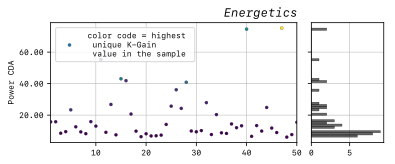

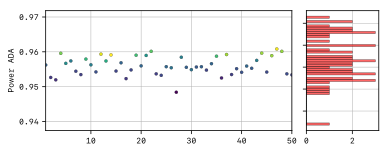

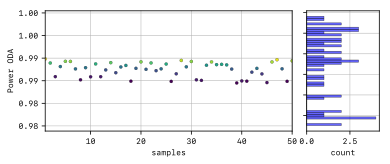

In [10]:
%config InlineBackend.figure_format = 'svg'

#--Cov
fig = plt.figure(figsize=(6,3), dpi=100);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])
ax_joint.scatter(np.arange(1, samples + 1),power2_c, marker='.',c = KalCovMaxVal, s = 40, edgecolor='black', linewidth=0.2)
ax_marg_y.hist(power2_c, orientation="horizontal",alpha=0.6, density=False, edgecolor='black', linewidth=0.5, bins = 50, facecolor = 'k')
ticks(ax_joint,8); ticks(ax_marg_y,8); plt.setp(ax_marg_y.get_xticklabels(), visible=True)
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);
l1 = ax_joint.legend(['color code = highest \n unique K-Gain \n value in the sample'], loc='upper left')
plt.setp(l1.texts, family='SF Mono', fontsize=8); 
ax_joint.set_ylabel('Power CDA',fontproperties=font,fontsize=8)
ax_joint.set_title('Energetics',fontproperties=fontit,fontsize=12, loc='right');
ax_joint.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax_joint.yaxis.set_major_formatter(major_formatter)

#--Atmosphere
fig = plt.figure(figsize=(6,3), dpi=100);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])
ax_joint.scatter(np.arange(1, samples + 1),power2_a, marker='.',c = KalAMaxVal, s = 40, edgecolor='black', linewidth=0.2)
ax_marg_y.hist(power2_a, orientation="horizontal",alpha=0.6, density=False, edgecolor='black', linewidth=0.5, bins = 50, facecolor = 'r')
ticks(ax_joint,8); ticks(ax_marg_y,8); plt.setp(ax_marg_y.get_xticklabels(), visible=True)
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);
ax_joint.set_ylabel('Power ADA',fontproperties=font,fontsize=8)
ax_joint.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#--Ocean
fig = plt.figure(figsize=(6,3), dpi=100);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])
ax_joint.scatter(np.arange(1, samples + 1),power2_o, marker='.',c = KalOMaxVal, s = 40, edgecolor='black', linewidth=0.2)
ax_marg_y.hist(power2_o, orientation="horizontal",alpha=0.6, density=False, edgecolor='black', linewidth=0.5, bins = 50, facecolor = 'b')
ticks(ax_joint,8); ticks(ax_marg_y,8); plt.setp(ax_marg_y.get_xticklabels(), visible=True)
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)
ax_marg_y.set_xlabel('count',fontproperties=font,fontsize=8)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);
ax_joint.set_xlabel('samples',fontproperties=font,fontsize=8)
ax_joint.set_ylabel('Power ODA',fontproperties=font,fontsize=8)
ax_joint.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Summary of variable values

## Model:

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}^{(10.0)}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix}\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix} = \begin{bmatrix}
    \mathrm{C}_\mathsf{OO}^{\,(-0.108)} & \mathrm{C}_\mathsf{OA}^{\,(+0.100)} \\
    \mathrm{C}_\mathsf{AO}^{\,(+0.010)} & \mathrm{C}_\mathsf{AA}^{\,(-0.112)}  
\end{bmatrix}\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix} + \begin{bmatrix}
    \emptyset \\
    \mathsf{F}^{\{\mathcal{G}\,=\,0.01\}}(t) 
\end{bmatrix}$$ 

## Initial Conditions:

$$\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}_{(t=0)} = \begin{bmatrix}
    1.0 \\
    1.0 
\end{bmatrix}$$

## Observational Variances

$$\begin{bmatrix}
    \sigma_{\mathsf{O},o} \\
    \sigma_{\mathsf{A},o} 
\end{bmatrix} = \begin{bmatrix}
    0.02 \\
    0.05 
\end{bmatrix}$$

## Duration:

Total duration: 5000 steps

Initialisation:  100 steps

## LACC:

Averaging window: 20 steps